In [21]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# And the display module for visualization
import librosa.display

In [22]:
test = False
if test:
    CONTENT_FILENAME = 'data/small_clips/classical_2.mp3'
    STYLE_FILENAME = 'data/small_clips/electronic_2.mp3'

In [23]:
if test:
    display(Audio(CONTENT_FILENAME))
    display(Audio(STYLE_FILENAME))

In [69]:
OUTPUT_FILENAME = 'outputs/out_3.wav'
display(Audio(OUTPUT_FILENAME))

In [70]:
if test:
    i1, sr1 = librosa.load(CONTENT_FILENAME)
    i2, sr2 = librosa.load(STYLE_FILENAME)
y, sr = librosa.load(OUTPUT_FILENAME)

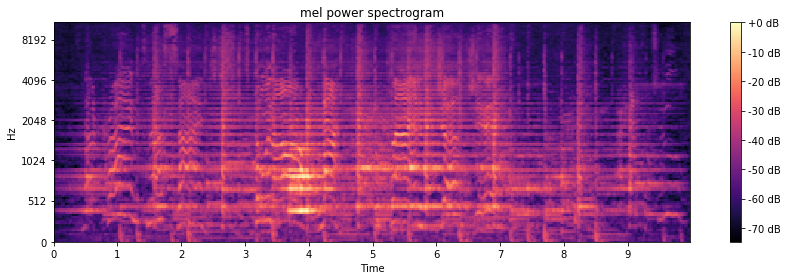

In [81]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

In [72]:
if test:
    y1_harmonic, y1_percussive = librosa.effects.hpss(i1)
    y2_harmonic, y2_percussive = librosa.effects.hpss(i2)
y_harmonic, y_percussive = librosa.effects.hpss(y)

if test:
    tempo1, beats = librosa.beat.beat_track(y=y1_percussive, sr=sr1)
    tempo2, beats = librosa.beat.beat_track(y=y2_percussive, sr=sr2)
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

if test:
    print('Estimated tempo for content:        %.2f BPM' % tempo1)
    print('Estimated tempo for style:        %.2f BPM' % tempo2)
print('Estimated tempo for output:        %.2f BPM' % tempo)

Estimated tempo for output:        112.35 BPM


# Harmonic-Percussive Source Separation

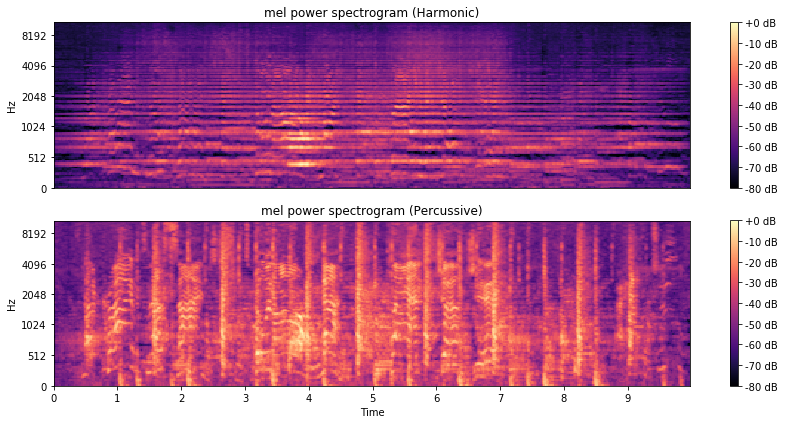

In [73]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# Chroma Features
Pitch class information

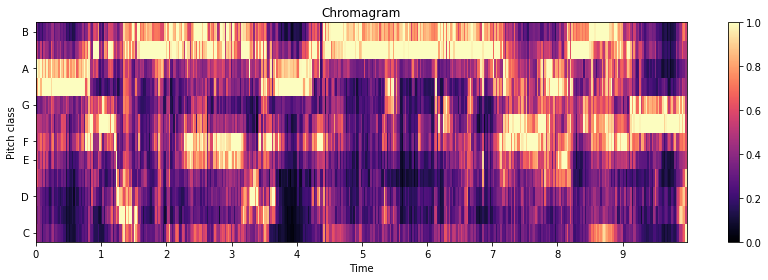

In [74]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()# We'll 
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

# Mel-Frequency Cepstral Constraints

represents texture and timbre of sound

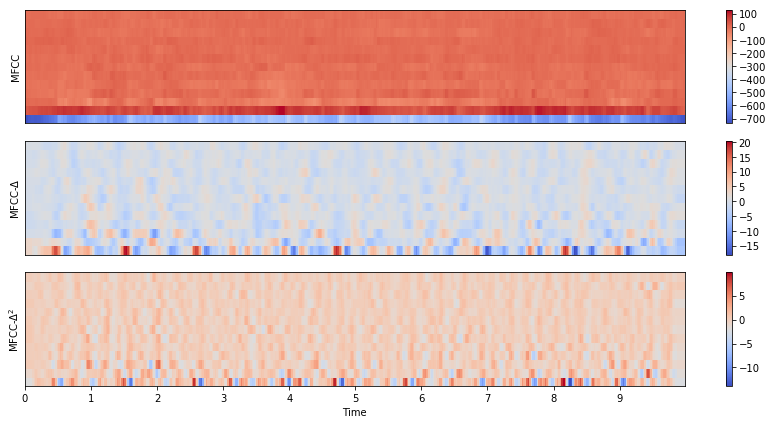

In [75]:


# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

# Beat tracking

Tempo estimate, frame indices of beat events

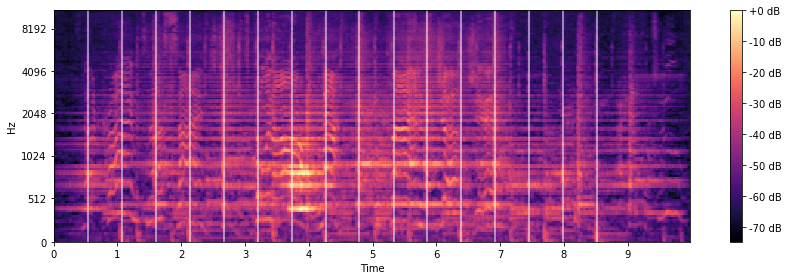

In [76]:

# Now, let's run the beat tracker.# Now,  
# We'll use the percussive component for this part
plt.figure(figsize=(12, 6))
tempo, beats = librosa.beat.beat_track(y=y_percussive, sr=sr)

# Let's re-draw the spectrogram, but this time, overlay the detected beats
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Let's draw transparent lines over the beat frames
plt.vlines(librosa.frames_to_time(beats),
           1, 0.5 * sr,
           colors='w', linestyles='-', linewidth=2, alpha=0.5)

plt.axis('tight')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()

In [77]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        112.35 BPM
First 5 beat frames:    [ 23  46  69  92 115]
First 5 beat times:     [ 0.53405896  1.06811791  1.60217687  2.13623583  2.67029478]


# Creating a classifier(?)

In [65]:
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [67]:
a_output, fs = read_audio_spectum(OUTPUT_FILENAME)

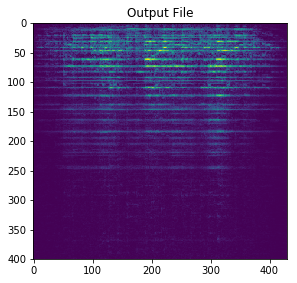

In [68]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Output File')
plt.imshow(a_output[:400,:])

In [12]:
N_FILTERS = 4096
N_SAMPLES = a_output.shape[1]
N_CHANNELS = a_output.shape[0]

a_output_tf = np.ascontiguousarray(a_output.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    out_features = net.eval(feed_dict={x: a_output_tf})
    
#     features = np.reshape(style_features, (-1, N_FILTERS))
#     style_gram = np.matmul(features.T, features) / N_SAMPLES
print(out_features.shape)

(1, 1, 420, 4096)


In [14]:
out_features

array([[[[ 0.20457463,  0.        ,  0.        , ...,  0.61472046,
           0.4099679 ,  0.96394926],
         [ 0.88505012,  0.        ,  0.18884227, ...,  1.48779488,
           0.66938549,  0.49761784],
         [ 0.64506078,  0.        ,  0.        , ...,  0.59243816,
           0.32389092,  0.        ],
         ..., 
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.21420078,  0.15116082],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.9302364 ],
         [ 0.        ,  0.        ,  0.        , ...,  0.10940856,
           0.        ,  1.70739675]]]], dtype=float32)